In [1]:
from numba import cuda, float32, int32
import numpy as np
import os
import time
import copy
import operator
import math
import matplotlib.pyplot as plt

# This next part is to avoid installing any packages. 
# On my machines I have an environment variable "LDPC" which contains the path to the project directory
# If you want a quick fix, you can comment the next line and set projectDir to where you cloned the repo.
projectDir = os.environ.get('LDPC')
if projectDir == None:
    import pathlib
    projectDir = pathlib.Path(__file__).parent.absolute()

# This part inserts the project directory into the environment path for the duration of this application.
import sys
sys.path.insert(1, projectDir)

# Import helper modules
import fileHandler
import common

# Next we set up a local prng, this is because we use np.random in several places, and we want each to have their own seed.
LDPC_LOCAL_PRNG = np.random.RandomState(7134066)
CODEWORD_LENGTH = 8176
# Now let's import the baseline matrix, I.e.: a matrix which is actually a good ECC
nearEarthParity = np.int32(fileHandler.readMatrixFromFile(str(projectDir) + '/codeMatrices/nearEarthParity.txt', 1022, 8176, 511, True, False, False))


In [2]:
#If everything went ok, then you should now be able to import ldpcCUDA.py
import ldpcCUDA



*** in test near earth
Time it took for code evaluation == 15
Throughput == 15649.60647262024bits per second.
0.39563919692811345
[-0.05026939  0.17176406]
 
-0.05027 x + 0.1718


/vol/bitbucket/megatron/imperial1/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


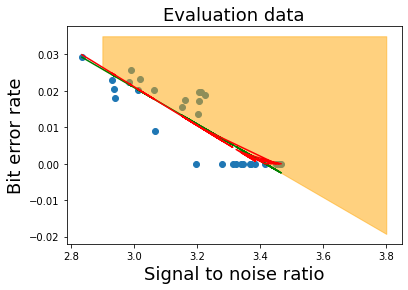

berDecoded [0.02117172 0.01221869 0.        ]


(<common.berStatistics at 0x7f8e46ce8070>, 'Near earth problem')

In [3]:
# As a sanity check, I usually call this function:
ldpcCUDA.testNearEarth(numOfTransmissions = 10, graphics = True)
# It would take a few minutes to finish, depending on the value of numberOfTransmissions.
# With respect to our discussion, numberOfTransmissions is the number of samples for each sample of s^2
# The output should be how much time it took (so for example 19 seconds on my machine with 30 transmissions) 
# and throughput (37693 bits per second on my machine). 
# The higher the throughput, the more samples we can take.

In [3]:
# Now let's see how to generate epsilons:

SNRdb = 3.6
SNR = 10 ** (SNRdb/10)
## Now use the definition: SNR = signal^2 / sigma^2
sigma = np.sqrt(0.5 / SNR)
# This is where we sample epsilon
epsilon = np.float32(LDPC_LOCAL_PRNG.normal(0, sigma, CODEWORD_LENGTH))
sigmaActual = np.sqrt((np.sum(epsilon ** 2)) / CODEWORD_LENGTH)
print(sigma)
print(sigmaActual)
# Now, you may want to know, if we just tried to take epsilon and do no ECC, how many "hard" errors are there.
# For that we first "slice" epsilon (i.e.: if epsilon[i] <= 0 then slicedEpsilon = 0, otherwise slicedEpsilon[i] = 1)

0.46718081737169276
0.46564316325419874


In [4]:
berUncoded, berDecoded, iterator, totalTime = ldpcCUDA.evaluateMatrixAndEpsilon(nearEarthParity, epsilon, numberOfIterations = 50, cudaDeviceNumber = 0) #You can also set the cuda device number using, the default is 0

Using cuda device number: 0


NvvmSupportError: libNVVM cannot be found. Do `conda install cudatoolkit`:
libnvvm.so: cannot open shared object file: No such file or directory

In [5]:
print("Without any error correction the bit error rate is %d / <length of codeword> == %f" % (berUncoded, berUncoded/8176))
print("After %d iterations of min-sum decoding, the bit error rate is %d / <length of codeword> == %f" % (iterator, berDecoded, berDecoded/8176))

NameError: name 'berUncoded' is not defined

In [4]:
# Now let's use the function evaluateCodeCode:
bStats = ldpcCUDA.evaluateCodeCuda(seed = 1, SNRpoints = [3.0, 3.2, 3.4, 3.6], numberOfIterations = 50, parityMatrix = nearEarthParity, numOfTransmissions = 30, G = 'None' , cudaDeviceNumber = 0)

In [12]:
# We get a berStats struct which contains all the SNR and BER entries we collected.
scatterSnr, scatterBer, scatterItr, snrAxis, averageSnrAxis, berData, averageNumberOfIterations = bStats.getStatsV2()

NameError: name 'scatterSnr' is not defined

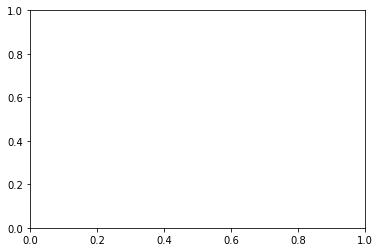

In [5]:
# And we can plot it as a scatter plot:
fig, ax = plt.subplots()
ax.scatter(scatterSnr, scatterBer)
ax.set_ylabel('Bit error rate', size = 18)
ax.set_xlabel('Signal to noise ratio', size = 18)
ax.set_title('Evaluation data', size = 18)

[-0.03381666  0.11826486]
[-0.02205899  0.08751112]
 
-0.03382 x + 0.1183
 
-0.02206 x + 0.08751


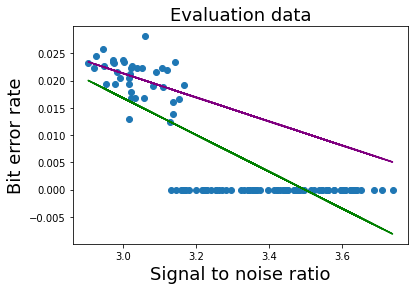

In [33]:
# Now let's do two linear fits:
# 1. A linear fit to the entire population
# 2. Linear fit JUST to the non - zero population)
p = np.polyfit(scatterSnr, scatterBer, 1)
reducedBer = scatterBer[scatterBer > 0]
reducedSnr = scatterSnr[scatterBer > 0]
q = np.polyfit(reducedSnr, reducedBer, 1)
print(p)
print(q)
trendP = np.poly1d(p)
trendQ = np.poly1d(q)
print(trendP)
print(trendQ)
# And add it to our plot:
fig, ax = plt.subplots()
ax.scatter(scatterSnr, scatterBer)
ax.set_ylabel('Bit error rate', size = 18)
ax.set_xlabel('Signal to noise ratio', size = 18)
ax.set_title('Evaluation data', size = 18)
ax.plot(scatterSnr, trendP(scatterSnr), color = 'g')
ax.plot(scatterSnr, trendQ(scatterSnr), color = 'purple')

[-0.03381666  0.11826486]
 
-0.03382 x + 0.1183
[-0.05039336  0.17019426]
 
-0.05039 x + 0.1702
[-0.06652609  0.21995063]
 
-0.06653 x + 0.22
[-0.08121961  0.26481385]
 
-0.08122 x + 0.2648
[-0.08345456  0.27160153]
 
-0.08345 x + 0.2716
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718
[-0.08352314  0.27180924]
 
-0.08352 x + 0.2718


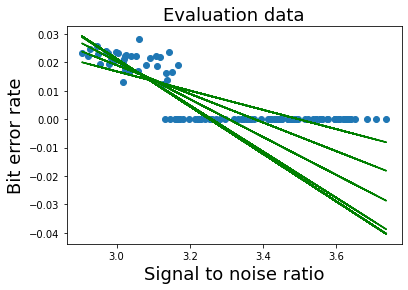

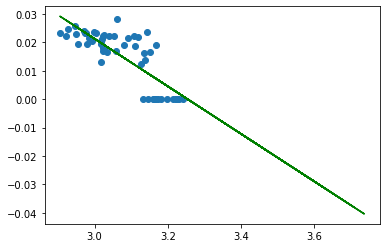

In [35]:
#Now let's try to do recursive linear fit, where each time we remove a sub-population from the zeros
ber = scatterBer
snr = scatterSnr
fig, ax = plt.subplots()
ax.scatter(scatterSnr, scatterBer)
ax.set_ylabel('Bit error rate', size = 18)
ax.set_xlabel('Signal to noise ratio', size = 18)
ax.set_title('Evaluation data', size = 18)
for i in range(20):
    p = np.polyfit(snr, ber, 1)
    print(p)
    trendP = np.poly1d(p)
    print(trendP)
    ax.plot(scatterSnr, trendP(scatterSnr), color = 'g')
    ber = ber[trendP(snr) > 0]
    snr = snr[trendP(snr) > 0]
fig, ax = plt.subplots()
ax.scatter(snr, ber)
ax.plot(scatterSnr, trendP(scatterSnr), color = 'g')